In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from ananke.graphs import ADMG
from ananke.identification import OneLineID
from ananke.estimation import CausalEffect
from ananke.estimation import AutomatedIF
from causallearn.utils.GraphUtils import GraphUtils
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgb
import seaborn as sns

### Loading the learnned model

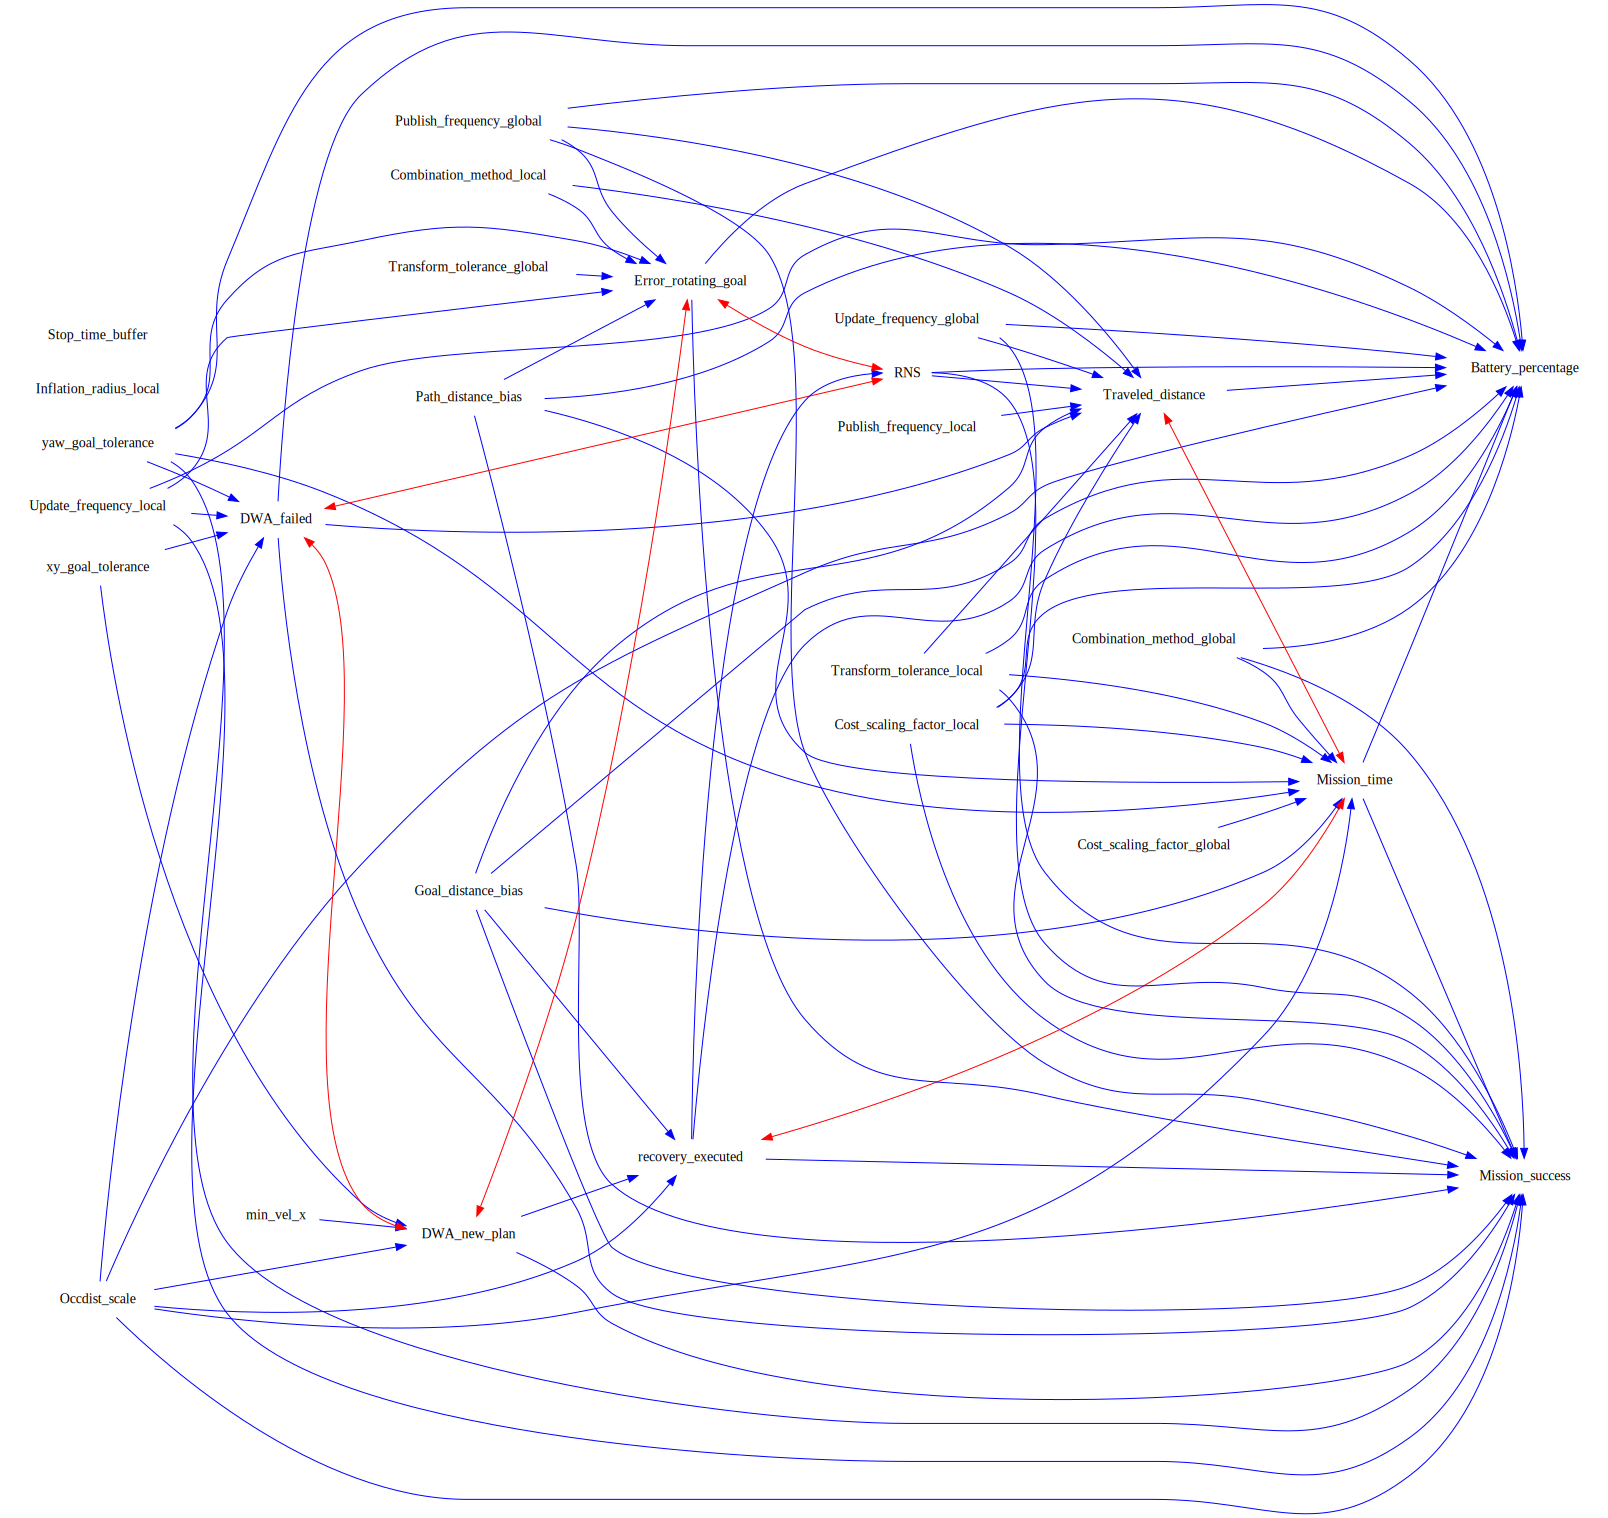

In [7]:
with open('model/care.model', 'rb') as fp:
    care = pickle.load(fp)      

vertices = care[0]
di_edges = care[1]
bi_edges = care[2]

G = ADMG(vertices, di_edges=di_edges, bi_edges=bi_edges)
G.draw(direction="LR")

### Ranking

#### Post-processing

In [8]:
raw = pd.read_csv('result/care_ace_result.csv', names=['Path', 'ACE', 'Ql', 'Qu'])
data = [raw['Path'], abs(raw['ACE']), abs(raw['Ql']), abs(raw['Qu'])]
df = pd.DataFrame(data)
df = df.T
rank_path = df.sort_values(by=['ACE'], ascending=False)
N = [df['ACE'], df['Ql'], df['Qu']]
norm = preprocessing.scale(N)
post = pd.DataFrame({'Path':raw['Path'], 'ACE':norm[0], 'Ql':norm[1], 'Qu':norm[2]})
rank_path.to_csv('result/rank_path.csv', index=False)
post.to_csv('result/cluster.csv', index=False, header=False)
display(rank_path)

,Path,ACE,Ql,Qu
142,"['Battery_percentage', 'DWA_failed', 'Occdist_...",432.608,580.896,293.056
78,"['Battery_percentage', 'Traveled_distance', 'R...",432.608,544.413,353.746
24,"['Battery_percentage', 'Mission_time', 'Travel...",432.608,455.158,335.206
96,"['Battery_percentage', 'RNS', 'recovery_execut...",432.608,632.158,342.182
95,"['Battery_percentage', 'RNS', 'recovery_execut...",432.608,525.532,258.885
...,...,...,...,...
250,"['Mission_success', 'RNS', 'Error_rotating_goa...",0.00461452,0.0527711,0.112831
148,"['Mission_success', 'Error_rotating_goal', 'Up...",0.00461452,0.174948,0.0247791
157,"['Mission_success', 'Error_rotating_goal', 'DW...",0.00461452,0.157957,0.0109119
198,"['Mission_success', 'Mission_time', 'Traveled_...",0.00461452,0.0138091,0.178548


#### Culstering energy

In [9]:
df = pd.read_csv('result/cluster_energy.csv', names=['ACE'])

# k means
kmeans = KMeans(n_clusters=4, random_state=0)
df['Rank'] = kmeans.fit_predict(df[['ACE']])

# get centroids
centroids = kmeans.cluster_centers_
cen_y = [i[0] for i in centroids] 
## add to df
df['cen_y'] = df.Rank.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})
colors = ['m', 'b', 'g', 'r']
df['c'] = df.Rank.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

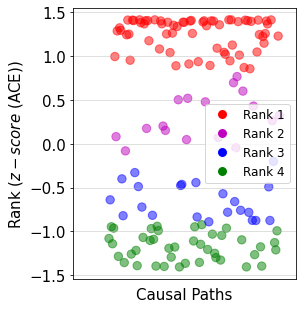

In [10]:
x = range(1, 147)

plt.rcParams.update({'figure.figsize':(4,5)})
plt.scatter(x, df.ACE, c=df.c, alpha = 0.5, s=70)

colors = ['r', 'm', 'b', 'g'] # sorted
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Rank {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]

# plot Defense mean
plt.xlim(-30, 160)

fontsize = 15
labelsize = 15
plt.xlabel('Causal Paths', fontsize=fontsize)
plt.xticks([])
plt.ylabel(r'Rank $(z-score\ \mathrm{(ACE)})$', fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.legend(handles=legend_elements, fontsize=12, loc='best', framealpha=0.8)
plt.gca().yaxis.grid(True, alpha=0.5)
plt.savefig('fig/rank_paths_energy.pdf', dpi=100, bbox_inches='tight') 

### Clustering mission success

In [11]:
df = pd.read_csv('result/cluster_mission.csv', names=['ACE'])

# k means
kmeans = KMeans(n_clusters=4, random_state=0)
df['Rank'] = kmeans.fit_predict(df[['ACE']])

# get centroids
centroids = kmeans.cluster_centers_
cen_y = [i[0] for i in centroids] 
## add to df
df['cen_y'] = df.Rank.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})
colors = ['m', 'g', 'r', 'b']
df['c'] = df.Rank.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

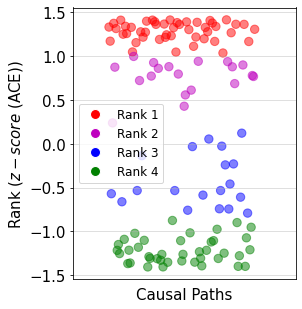

In [12]:
x = range(1, 126)

plt.rcParams.update({'figure.figsize':(4,5)})
plt.scatter(x, df.ACE, c=df.c, alpha = 0.5, s=70)

colors = ['r', 'm', 'b', 'g'] # sorted
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Rank {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]

# plot Defense mean
plt.xlim(-30, 160)

fontsize = 15
labelsize = 15
plt.xlabel('Causal Paths', fontsize=fontsize)
plt.xticks([])
plt.ylabel(r'Rank $(z-score\ \mathrm{(ACE)})$', fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.legend(handles=legend_elements, fontsize=12, loc='best', framealpha=0.8)
plt.gca().yaxis.grid(True, alpha=0.5)
plt.savefig('fig/rank_paths_mission.pdf', dpi=100, bbox_inches='tight') 

#### Validating ranks

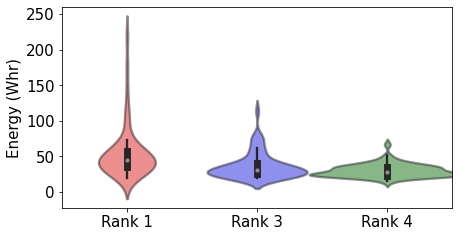

In [13]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(7,3.7)})

v = sns.violinplot(data= rank_e, x='Rank', y='Energy (Whr)',
                     inner='box', bw=.4, width=1.2, linewidth=2.3, palette=['r', 'b', 'g'])

#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("Energy (Whr)", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
# plt.gca().yaxis.grid(True, alpha=0.35)
plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_e_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

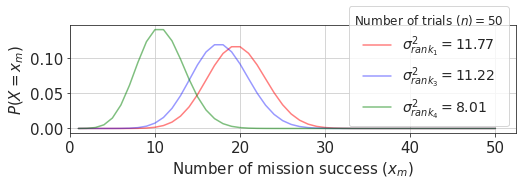

In [37]:
rank_e = pd.read_csv("result/exp/mission_proba_sim.csv")

plt.rcParams.update({'figure.figsize':(8,2)})
x = range(1,51)
# plt.bar(x, rank_e['Rank 1'], alpha=0.5, color='r', width=0.8, label=r'$\sigma^2_{rank_1}=11.77$')
# plt.bar(x, rank_e['Rank 2'], alpha=0.4, color='b', width=0.8, label=r'$\sigma^2_{rank_3}=11.22$')
# plt.bar(x, rank_e['Rank 3'], alpha=0.5, color='g', width=0.8, label=r'$\sigma^2_{rank_4}=8.01$')

plt.plot(x, rank_e['Rank 1'], alpha=0.5, color='r', label=r'$\sigma^2_{rank_1}=11.77$')
plt.plot(x, rank_e['Rank 2'], alpha=0.4, color='b',  label=r'$\sigma^2_{rank_3}=11.22$')
plt.plot(x, rank_e['Rank 3'], alpha=0.5, color='g', label=r'$\sigma^2_{rank_4}=8.01$')


fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
# v.set(xlabel=None)
plt.xlabel(r"Number of mission success ($x_m$)", fontsize=fontsize)
plt.ylabel(r"$P(X=x_m)$", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.legend(title=r'$\mathrm{Number\ of\ trials\ }(n)=50$',title_fontsize=12,fontsize=14, loc='best')
plt.setp(v.collections, alpha=.5)
plt.xlim(left=0)
plt.savefig('fig/exp_rank_m_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

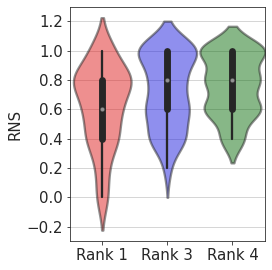

In [15]:
rank_ms = pd.read_csv("result/exp/mission_success.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.3)})

v = sns.violinplot(data= rank_ms, x='Rank', y='RNS',
                     inner='box', bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])

#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_ms, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

colors = ['r', 'b', 'g']

# legend_elements = [Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 0.26$', 
#                     markerfacecolor='r', alpha=0.5, markersize=10),
#                     Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 0.25$', 
#                     markerfacecolor='b', alpha=0.5, markersize=10),
#                     Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 0.2$', 
#                     markerfacecolor='g', alpha=0.5, markersize=10),]

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("RNS", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(handles=legend_elements, fontsize=12, loc='best', framealpha=0.5)
plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_rns_ms_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

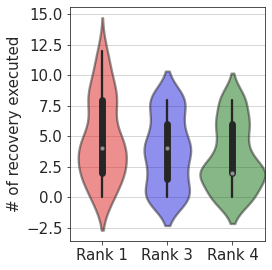

In [16]:
rank_ms = pd.read_csv("result/exp/mission_success.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.3)})

v = sns.violinplot(data= rank_ms, x='Rank', y='Recovery_executed',
                     inner='box', bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])

#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_ms, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

# legend_elements = [Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 3.2$', 
#                     markerfacecolor='r', alpha=0.5, markersize=10),
#                     Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 2.89$', 
#                     markerfacecolor='b', alpha=0.5, markersize=10),
#                     Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 2.74$', 
#                     markerfacecolor='g', alpha=0.5, markersize=10),]

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("# of recovery executed", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(handles=legend_elements, fontsize=12, loc='best', framealpha=0.5)
# plt.gca().yaxis.grid(True, alpha=0.35)
plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_ms_re_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

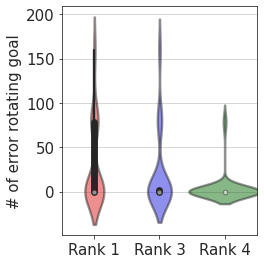

In [17]:
rank_ms = pd.read_csv("result/exp/mission_success.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.2)})

v = sns.violinplot(data= rank_ms, x='Rank', y='Error_rotating_goal',
                     inner='box', bw=.4, width=1.1, linewidth=2.3, palette=['r', 'b', 'g'])

#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_ms, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

# legend_elements = [Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 43.64$', 
#                     markerfacecolor='r', alpha=0.5, markersize=10),
#                     Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 2.89$', 
#                     markerfacecolor='b', alpha=0.5, markersize=10),
#                     Line2D([0], [0], marker='o', color='w', label=r'$\sigma = 2.74$', 
#                     markerfacecolor='g', alpha=0.5, markersize=10),]

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("# of error rotating goal", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(handles=legend_elements, fontsize=12, loc='best', framealpha=0.5)
# plt.gca().yaxis.grid(True, alpha=0.35)
plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_erg_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

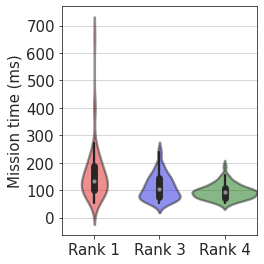

In [18]:
rank_ms = pd.read_csv("result/exp/mission_success.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.2)})

v = sns.violinplot(data= rank_ms, x='Rank', y='Mission_time',
                     inner='box', bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])

#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_ms, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("Mission time (ms)", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
# plt.gca().yaxis.grid(True, alpha=0.35)
plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_ms_mt_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

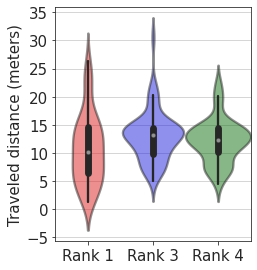

In [19]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.3)})

v = sns.violinplot(data= rank_e, x='Rank', y='Traveled_distance',
                     inner='box', bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])

                     

#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("Traveled distance (meters)", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
sns.set_style("ticks",{'axes.grid' : True})
plt.setp(v.collections, alpha=.5)
plt.savefig('fig/exp_rank_td_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

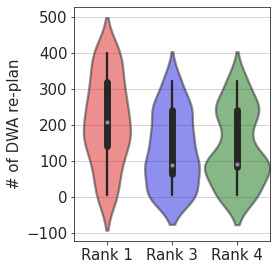

In [20]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.3)})

v = sns.violinplot(data= rank_e, x='Rank', y='DWA_new_plan',
                     bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])
#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("# of DWA re-plan", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
sns.set_style("ticks",{'axes.grid' : True})
plt.setp(v.collections, alpha=.5)
plt.savefig('fig/exp_rank_dwa_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

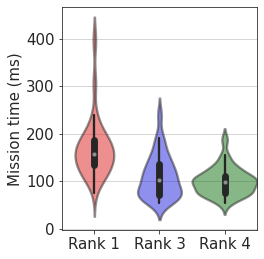

In [21]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.1)})

v = sns.violinplot(data= rank_e, x='Rank', y='Mission_time',
                     bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])
#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("Mission time (ms)", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
sns.set_style("ticks",{'axes.grid' : True})
plt.setp(v.collections, alpha=.5)
plt.savefig('fig/exp_rank_mt_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

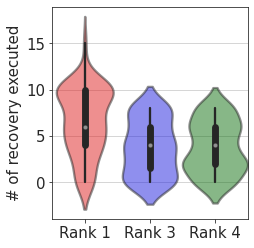

In [22]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(3.5,3.9)})

v = sns.violinplot(data= rank_e, x='Rank', y='Recovery_executed',
                     bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])
#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("# of recovery executed", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
sns.set_style("ticks",{'axes.grid' : True})
plt.setp(v.collections, alpha=.5)
plt.savefig('fig/exp_rank_re_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

### Energy

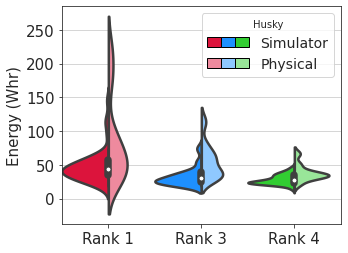

In [23]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(5,4)})

v = sns.violinplot(data= rank_e, x='Rank', y='Energy (Whr)', hue='Husky', split=True,
                     inner='box', bw=.4, width=1, linewidth=2.5)
colors = ['crimson', 'dodgerblue', 'limegreen']

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['gray', 'gray', 'gray'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

handles = []
for ind, violin in enumerate(v.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))
v.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=['Simulator','Physical'], fontsize=14,
         title="Husky", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})


fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("Energy (Whr)", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
# plt.gca().yaxis.grid(True, alpha=0.35)
# plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_e_sim.pdf', dpi=100, bbox_inches='tight')
plt.show()

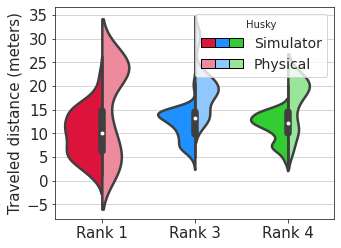

In [24]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(5,3.9)})

v = sns.violinplot(data= rank_e, x='Rank', y='Traveled_distance', hue='Husky', split=True,
                     inner='box', bw=.4, width=0.8, linewidth=2.5)

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)


handles = []
for ind, violin in enumerate(v.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))
v.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=['Simulator','Physical'], fontsize=14,
         title="Husky", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})


fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("Traveled distance (meters)", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
sns.set_style("ticks",{'axes.grid' : True})
# plt.setp(v.collections, alpha=.5)
plt.savefig('fig/exp_rank_td_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

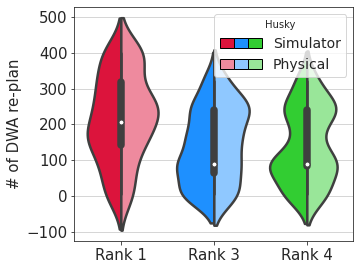

In [25]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(5,4.3)})

v = sns.violinplot(data= rank_e, x='Rank', y='DWA_new_plan', hue='Husky', split=True,
                     bw=.4, width=0.8, linewidth=2.5)

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

handles = []
for ind, violin in enumerate(v.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))
v.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=['Simulator','Physical'], fontsize=14,
         title="Husky", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("# of DWA re-plan", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
sns.set_style("ticks",{'axes.grid' : True})
# plt.setp(v.collections, alpha=.5)
plt.savefig('fig/exp_rank_dwa_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

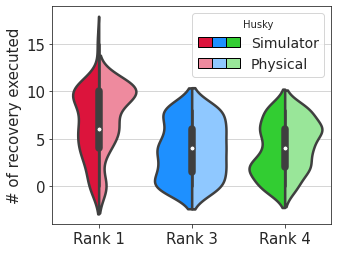

In [26]:
rank_e = pd.read_csv("result/exp/energy.csv")

plt.rcParams.update({'figure.figsize':(5,4)})

v = sns.violinplot(data= rank_e, x='Rank', y='Recovery_executed', hue='Husky', split=True,
                     bw=.4, width=0.8, linewidth=2.5)
#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_e, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

handles = []
for ind, violin in enumerate(v.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))
v.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=['Simulator','Physical'], fontsize=14,
         title="Husky", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})


fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("# of recovery executed", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(fontsize=12, loc='best')
sns.set_style("ticks",{'axes.grid' : True})
# plt.setp(v.collections, alpha=.5)
plt.savefig('fig/exp_rank_re_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

### Mission success

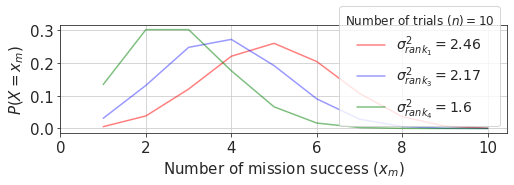

In [39]:
rank_e = pd.read_csv("result/exp/mission_proba_real.csv")

plt.rcParams.update({'figure.figsize':(8,2)})
x = range(1,11)
plt.plot(x, rank_e['Rank 1'], alpha=0.5, color='r', label=r'$\sigma^2_{rank_1}=2.46$')
plt.plot(x, rank_e['Rank 2'], alpha=0.4, color='b', label=r'$\sigma^2_{rank_3}=2.17$')
plt.plot(x, rank_e['Rank 3'], alpha=0.5, color='g', label=r'$\sigma^2_{rank_4}=1.6$')


fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
# v.set(xlabel=None)
plt.xlabel(r"Number of mission success ($x_m$)", fontsize=fontsize)
plt.ylabel(r"$P(X=x_m)$", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(title=r'$\mathrm{Number\ of\ trials\ }(n)=10$',title_fontsize=12,fontsize=14, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
#                 mode="expand", borderaxespad=0, ncol=3)
plt.legend(title=r'$\mathrm{Number\ of\ trials\ }(n)=10$',title_fontsize=12,fontsize=14, loc='best')
plt.setp(v.collections, alpha=.5)
plt.xlim(left=0)
plt.savefig('fig/exp_rank_m_real.pdf', dpi=100, bbox_inches='tight') 
plt.show()

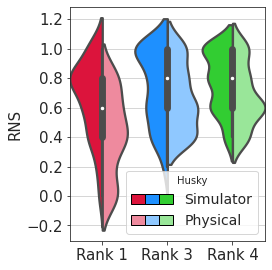

In [28]:
rank_ms = pd.read_csv("result/exp/mission_success.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.3)})

v = sns.violinplot(data= rank_ms, x='Rank', y='RNS', hue='Husky', split=True,
                     inner='box', bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])

#ax = sns.violinplot(x, y=rank_3, color='r', inner=None, linewidth=0, saturation=0.5)

# b = sns.boxplot(data=rank_ms, x='Rank', y='Energy (Whr)', saturation=0.3, width=0.15,
#             palette=['r', 'b', 'g'], boxprops={'zorder': 1}, flierprops={"marker": "."},  notch=True, ax=v)

colors = ['crimson', 'dodgerblue', 'limegreen']

handles = []
for ind, violin in enumerate(v.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))
v.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=['Simulator','Physical'], fontsize=14,
         title="Husky", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("RNS", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(handles=legend_elements, fontsize=12, loc='best', framealpha=0.5)
# plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_rns_ms_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

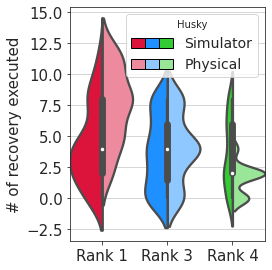

In [29]:
rank_ms = pd.read_csv("result/exp/mission_success.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.3)})

v = sns.violinplot(data= rank_ms, x='Rank', y='Recovery_executed', hue='Husky', split=True,
                     inner='box', bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])

colors = ['crimson', 'dodgerblue', 'limegreen']

handles = []
for ind, violin in enumerate(v.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))
v.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=['Simulator','Physical'], fontsize=14,
         title="Husky", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})

fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("# of recovery executed", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(handles=legend_elements, fontsize=12, loc='best', framealpha=0.5)
# plt.gca().yaxis.grid(True, alpha=0.35)
# plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_ms_re_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

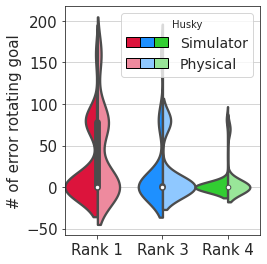

In [30]:
rank_ms = pd.read_csv("result/exp/mission_success.csv")

plt.rcParams.update({'figure.figsize':(3.5,4.2)})

v = sns.violinplot(data= rank_ms, x='Rank', y='Error_rotating_goal', hue='Husky', split=True,
                     inner='box', bw=.4, width=1, linewidth=2.3, palette=['r', 'b', 'g'])

colors = ['crimson', 'dodgerblue', 'limegreen']

handles = []
for ind, violin in enumerate(v.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)
    handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor='black'))
v.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=['Simulator','Physical'], fontsize=14,
         title="Husky", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)})


fontsize = 15
labelsize = 15
# plt.xlabel('Ranks', fontsize=fontsize)
v.set(xlabel=None)
plt.ylabel("# of error rotating goal", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
# plt.legend(handles=legend_elements, fontsize=12, loc='best', framealpha=0.5)
# plt.gca().yaxis.grid(True, alpha=0.35)
#plt.setp(v.collections, alpha=.5)
sns.set_style("ticks",{'axes.grid' : True})
plt.savefig('fig/exp_rank_erg_sim.pdf', dpi=100, bbox_inches='tight') 
plt.show()

#### Intro

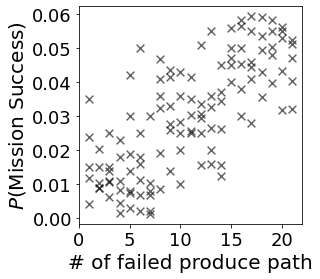

In [13]:
df = pd.read_csv('result/intro.csv')
s = 60
plt.rcParams.update({'figure.figsize':(4,4)})
plt.scatter(df['DWA failed_1'], df['PofMS_1'], color = 'k', alpha=0.6, marker='x', s=s,  label='occ_1')
plt.scatter(df['DWA failed_2'], df['PofMS_2'], color = 'k', alpha=0.6, marker='x', s=s, label='occ_2')
plt.scatter(df['DWA failed_3'], df['PofMS_3'], color = 'k', alpha=0.6, marker='x', s=s, label='occ_3')

fontsize = 20
labelsize = 18

plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.xlabel('# of failed produce path', fontsize=fontsize)
plt.ylabel(r'$P($Mission Success$)$', fontsize=fontsize)
plt.savefig('fig/intro_ml.pdf', dpi=100, bbox_inches='tight')

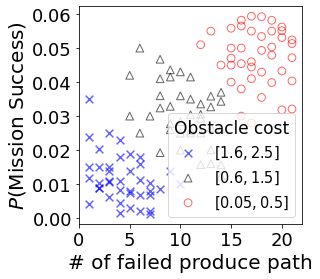

In [19]:
df = pd.read_csv('result/intro.csv')
s = 60
plt.rcParams.update({'figure.figsize':(4,4)})
plt.scatter(df['DWA failed_1'], df['PofMS_1'], color = 'b', marker='x', alpha=0.6, s=s, label=r'$[1.6, 2.5]$')
plt.scatter(df['DWA failed_2'], df['PofMS_2'], color = 'k', marker='^', alpha=0.6, s=s,facecolors='none',  label=r'$[0.6, 1.5]$')
plt.scatter(df['DWA failed_3'], df['PofMS_3'], color = 'r', marker='o',  alpha=0.6, s=s, facecolors='none', label=r'$[0.05, 0.5]$')

fontsize = 20
labelsize = 18

plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.xlabel('# of failed produce path', fontsize=fontsize)
plt.ylabel(r'$P($Mission Success$)$', fontsize=fontsize)

plt.legend(title='Obstacle cost',title_fontsize=17, fontsize=14.5, loc='lower right')
plt.savefig('fig/intro_causal.pdf', dpi=100, bbox_inches='tight')